# InceptionResNetV2

## Get embeddings
I just download this model from Keras and inference it following their example

In [1]:
# Load images
import numpy as np
from PIL import Image
import os

# Training
image_folder = "images/training_imgs"

# Break into categories
clothing_images = [Image.open(os.path.join(image_folder, file)) for file in os.listdir(image_folder) if file.endswith("c.png")]
clothing_labels = [file.split("-")[0].split("_") for file in os.listdir(image_folder) if file.endswith("c.png")]
clothing_labels = [[lab[0], lab[1], lab[2][:-1]] if lab[2].endswith("s") else lab for lab in clothing_labels]

full_body_images = [Image.open(os.path.join(image_folder, file)) for file in os.listdir(image_folder) if file.endswith("fb.png")]
full_body_labels = [file.split("-")[0].split("_") for file in os.listdir(image_folder) if file.endswith("fb.png")]
full_body_filenames = [file for file in os.listdir(image_folder) if file.endswith("fb.png")]
full_body_labels = [[lab[0], lab[1], lab[2][:-1]] if lab[2].endswith("s") else lab for lab in full_body_labels]

# # Test
# image_folder = "images/example_imgs"

# # Break into categories
# test_clothing_images = [Image.open(os.path.join(image_folder, file)) for file in os.listdir(image_folder) if file.endswith("c.png")]
# test_clothing_labels = [file.split("-")[0].split("_") for file in os.listdir(image_folder) if file.endswith("c.png")]
# test_clothing_labels = [[lab[0], lab[1], lab[2][:-1]] if lab[2].endswith("s") else lab for lab in clothing_labels]

In [5]:
# Create embeddings
import tensorflow as tf

def sample_generator(dataset):
    for sample in dataset:
        yield tf.keras.applications.vgg19.preprocess_input(np.array(sample))

img_spec = tf.TensorSpec((488, 488, 3), float)
ds_clothing = tf.data.Dataset.from_generator(lambda: sample_generator(clothing_images), output_signature=img_spec).batch(32)
ds_outfit = tf.data.Dataset.from_generator(lambda: sample_generator(full_body_images), output_signature=img_spec).batch(32)
# ds_test = tf.data.Dataset.from_generator(lambda: sample_generator(test_clothing_images), output_signature=img_spec).batch(32)

model = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(488, 488, 3),
    pooling="avg"
)

clothing_embed = model.predict(ds_clothing)
full_body_embed = model.predict(ds_outfit)
# test_embed = model.predict(ds_test)

I0000 00:00:1714890276.707227 1187038 service.cc:145] XLA service 0x72307c003ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714890276.707279 1187038 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1714890276.707285 1187038 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-05-05 02:24:36.745193: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-05 02:24:36.911808: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


      2/Unknown 14s 103ms/step

I0000 00:00:1714890289.960005 1187038 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step


2024-05-05 02:25:09.343756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/ian/miniconda3/envs/tf/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 720ms/step


2024-05-05 02:25:23.919152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Visualize model embeddings

In [6]:
# Load images
from pickle import load
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

embeds = load(open("jepa_encodings_train.pkl", "rb"))

# Break into categories
clothing_pca = PCA(n_components=2).fit(clothing_embed)
print(clothing_pca.explained_variance_ratio_, sum(clothing_pca.explained_variance_ratio_))
clothing_pca = clothing_pca.transform(clothing_embed)
clothing_tsne = TSNE().fit_transform(clothing_embed)

full_body_pca = PCA(n_components=2).fit(full_body_embed)
print(full_body_pca.explained_variance_ratio_, sum(full_body_pca.explained_variance_ratio_))
full_body_pca = full_body_pca.transform(full_body_embed)
full_body_tsne = TSNE().fit_transform(full_body_embed)

[0.22807302 0.13624415] 0.3643171638250351
[0.19389093 0.09798192] 0.29187285155057907


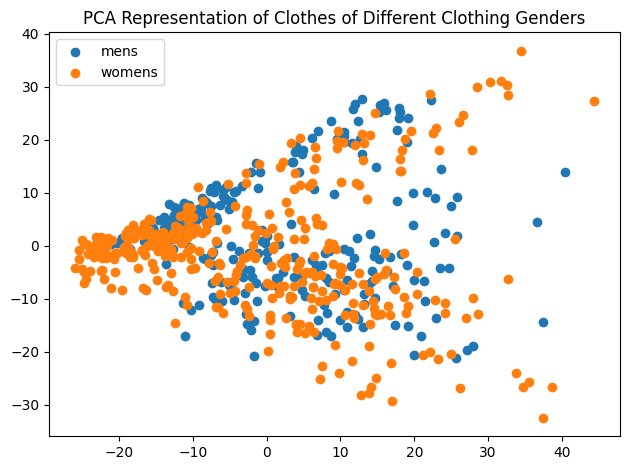

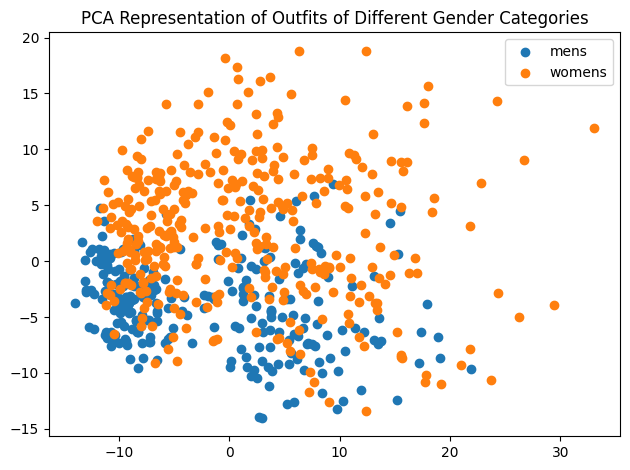

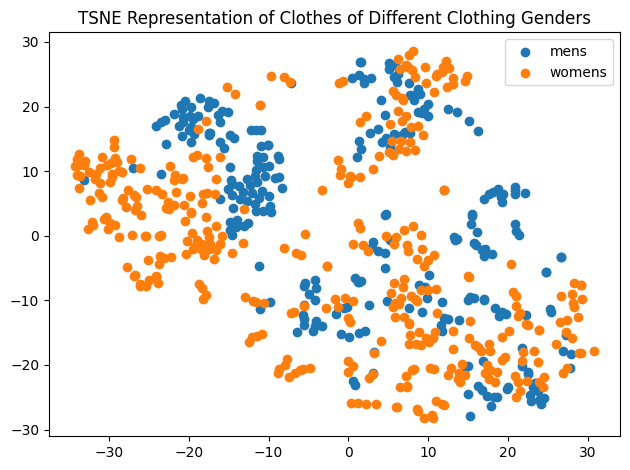

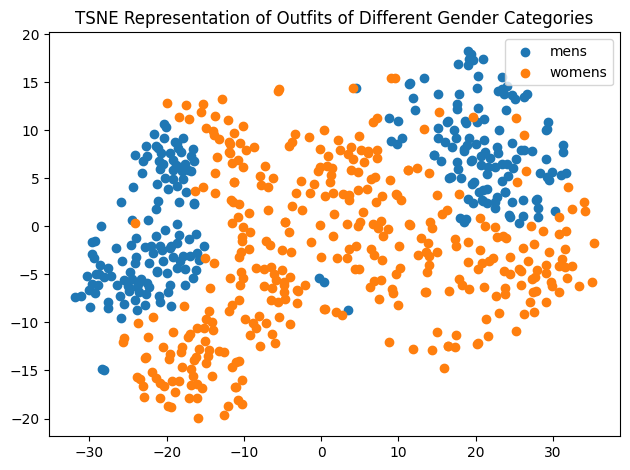

In [9]:
# Plot gendered items
import matplotlib.pyplot as plt

for gender in ["mens", "womens"]:
    plt.scatter(
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][1] == gender]][:, 0],
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("PCA Representation of Clothes of Different Clothing Genders")
plt.tight_layout()
plt.legend()
plt.show()

for gender in ["mens", "womens"]:
    plt.scatter(
        full_body_pca[[i for i in range(len(clothing_pca)) if full_body_labels[i][1] == gender]][:, 0],
        full_body_pca[[i for i in range(len(clothing_pca)) if full_body_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("PCA Representation of Outfits of Different Gender Categories")
plt.tight_layout()
plt.legend()
plt.show()

for gender in ["mens", "womens"]:
    plt.scatter(
        clothing_tsne[[i for i in range(len(clothing_pca)) if clothing_labels[i][1] == gender]][:, 0],
        clothing_tsne[[i for i in range(len(clothing_pca)) if clothing_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("TSNE Representation of Clothes of Different Clothing Genders")
plt.tight_layout()
plt.legend()
plt.show()

for gender in ["mens", "womens"]:
    plt.scatter(
        full_body_tsne[[i for i in range(len(clothing_pca)) if full_body_labels[i][1] == gender]][:, 0],
        full_body_tsne[[i for i in range(len(clothing_pca)) if full_body_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("TSNE Representation of Outfits of Different Gender Categories")
plt.tight_layout()
plt.legend()
plt.show()

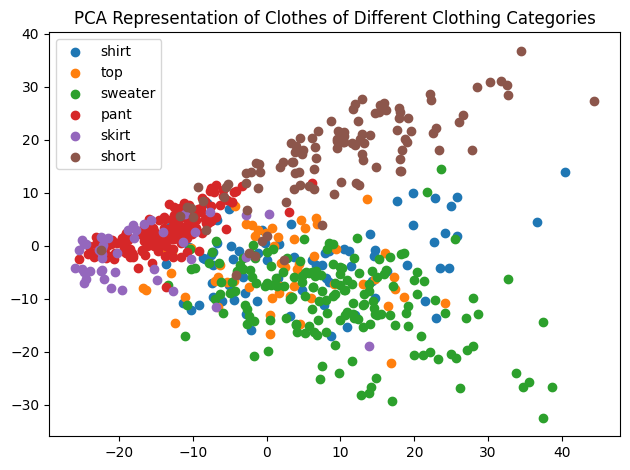

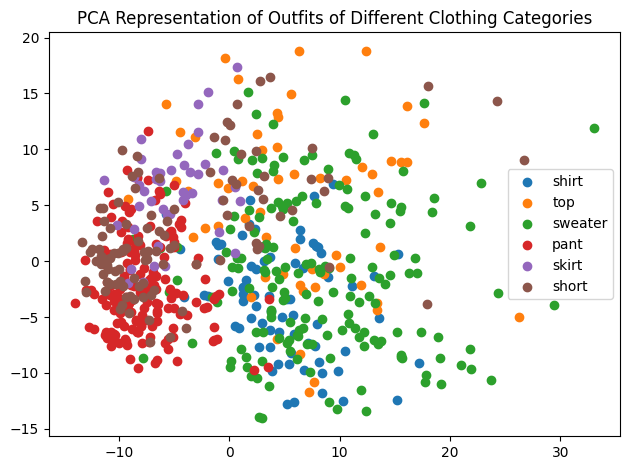

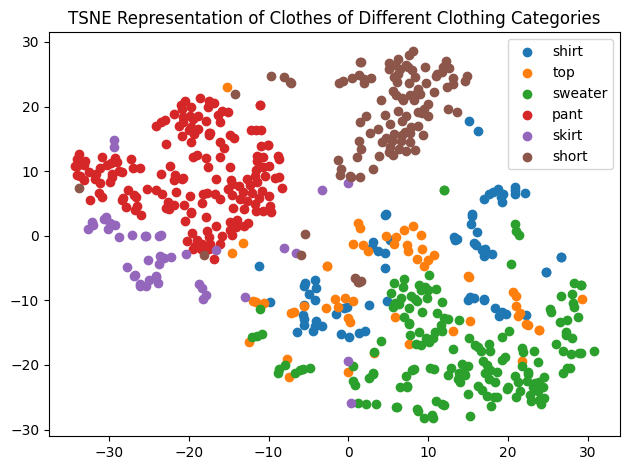

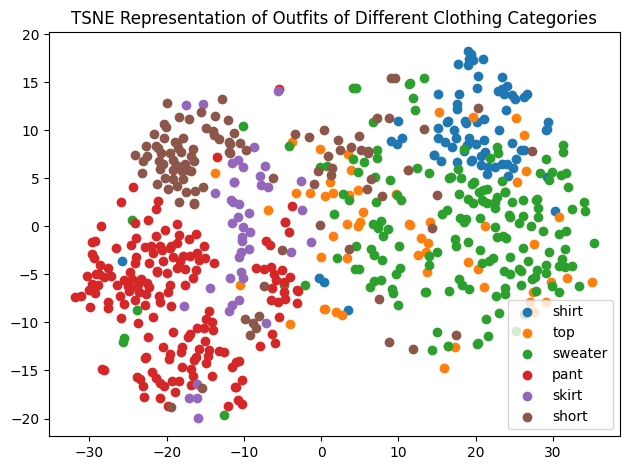

In [10]:
# Plot types of items
for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:
    plt.scatter(
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][2] == item]][:, 0],
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("PCA Representation of Clothes of Different Clothing Categories")
plt.tight_layout()
plt.legend()
plt.show()

for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:
    plt.scatter(
        full_body_pca[[i for i in range(len(clothing_pca)) if full_body_labels[i][2] == item]][:, 0],
        full_body_pca[[i for i in range(len(clothing_pca)) if full_body_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("PCA Representation of Outfits of Different Clothing Categories")
plt.tight_layout()
plt.legend()
plt.show()

for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:
    plt.scatter(
        clothing_tsne[[i for i in range(len(clothing_pca)) if clothing_labels[i][2] == item]][:, 0],
        clothing_tsne[[i for i in range(len(clothing_pca)) if clothing_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("TSNE Representation of Clothes of Different Clothing Categories")
plt.tight_layout()
plt.legend()
plt.show()

for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:
    plt.scatter(
        full_body_tsne[[i for i in range(len(clothing_pca)) if full_body_labels[i][2] == item]][:, 0],
        full_body_tsne[[i for i in range(len(clothing_pca)) if full_body_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("TSNE Representation of Outfits of Different Clothing Categories")
plt.tight_layout()
plt.legend()
plt.show()